In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224,224)):
    """
    Process an image and its corresponding labels for training.

    Parameters:
    ----------
    image_path : str
        The path to the image file.
    family : str
        The family label of the image.
    genus : str
        The genus label of the image.
    species : str
        The species label of the image.
    family_labels : tf.Tensor
        Tensor of unique family labels.
    genus_labels : tf.Tensor
        Tensor of unique genus labels.
    species_labels : tf.Tensor
        Tensor of unique species labels.

    Returns:
    -------
    img : tf.Tensor
        The processed image tensor.
    labels : dict
        A dictionary containing one-hot encoded labels for family, genus, and species.
    """
    # Load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, image_size)
    #img = tf.image.resize_with_pad(img, target_height=image_size[0], target_width=image_size[1])

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224,224)):
    """
    Build a TensorFlow dataset from a DataFrame containing image paths and taxonomic labels.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing the following columns:
        - 'path': The path to the image.
        - 'Family': The family label of the image.
        - 'Genus': The genus label of the image.
        - 'Species': The species label of the image.
    batch_size : int, optional
        Batch size for training. Default is 32.

    Returns:
    -------
    image_label_ds : tf.data.Dataset
        A TensorFlow dataset with images and one-hot encoded labels.
    family_labels : list
        A sorted list of unique family labels.
    genus_labels : list
        A sorted list of unique genus labels.
    species_labels : list
        A sorted list of unique species labels.
    """
    # Extract the unique family, genus, and species from the dataframe
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Create a TensorFlow dataset from the dataframe's paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['family'].values, df['genus'].values, df['species'].values)
    )

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size=image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(df))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    

In [12]:
settings = dict(
    batch_size = 64,
    epochs = 10,
    ftun_epochs = 10,
    img_size = (128, 128),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

df_lab = image_directory_to_pandas("/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/Species_v02")
df_web = image_directory_to_pandas("/Volumes/T7_shield/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas("/Volumes/T7_shield/CryptoVision/Data/inaturalist/Species_v02")

df = pd.concat([df_lab, df_web, df_inatlist], ignore_index=True, axis=0)

# find in the species column the values with lass than 50 occurences
counts = df['species'].value_counts()
df = df[df['species'].isin(counts[counts > 50].index)]

df.head(10)


,image_path,folder_label,family,genus,species
0,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
1,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
2,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
3,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
4,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
5,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
6,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
7,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
8,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
9,/Volumes/T7_shield/CryptoVision/Data/fish_func...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus


In [13]:

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

# Display the sizes of each split
print(f"Training Sample size: {len(train_df)}")
print(f"Validation Sample size: {len(val_df)}")
print(f"Test Sample size: {len(test_df)}")

train_ds, family_labels, genus_labels, species_labels = build_dataset_from_dataframe(train_df, settings['batch_size'], settings['img_size'])  
val_ds, _, _, _ = build_dataset_from_dataframe(val_df, settings['batch_size'], settings['img_size'])
test_ds, _, _, _ = build_dataset_from_dataframe(test_df, settings['batch_size'], settings['img_size'])

Training Sample size: 13040
Validation Sample size: 2795
Test Sample size: 2795


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)


2025-01-04 17:09:18.438605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 2452 of 13040
2025-01-04 17:09:28.455319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 5083 of 13040
2025-01-04 17:09:48.439027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 10373 of 13040
2025-01-04 17:09:58.443990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 12940 of 13040
2025-01-04 17:09:58.792620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-04 17:09:59.528154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-04 17:10:00.378120: I tensorflow/core/framework/local_rendezvous.cc:404] Local rende

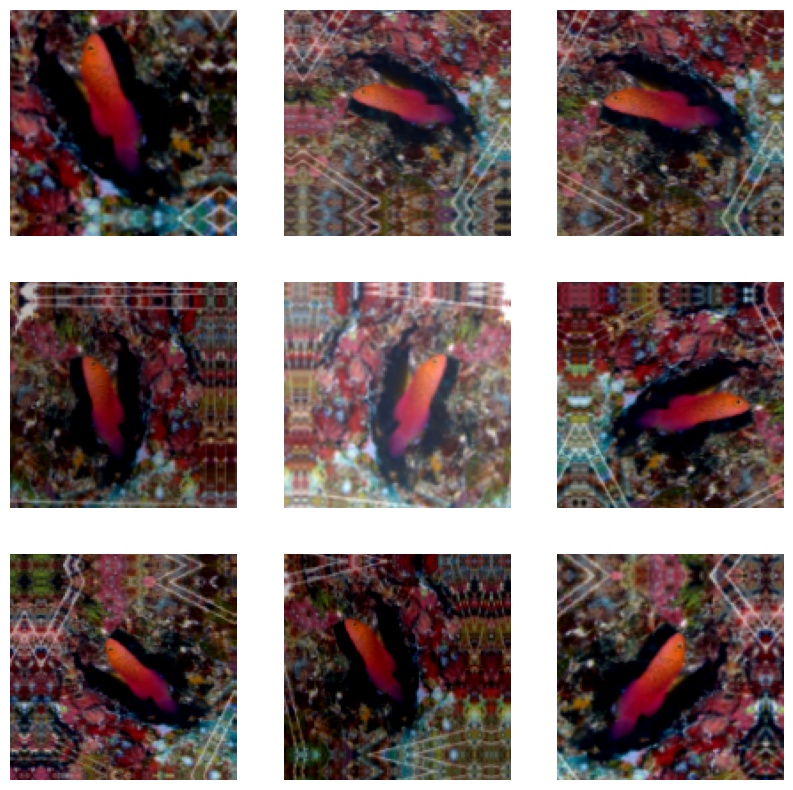

In [16]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=settings['img_size'] + (3,),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=settings['img_size'] + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Shared dense layer for better feature learning
shared_layer = tf.keras.layers.Dense(512, activation='relu', name='shared_layer')(x)

# Define family output
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(shared_layer)

# Concatenate the family output with the base model output
family_features = tf.keras.layers.Concatenate()([shared_layer, family_output])

# Define genus output, using family features as additional input
genus_hidden = tf.keras.layers.Dense(256, activation='relu')(family_features)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Concatenate the family and genus outputs with the base model output
genus_features = tf.keras.layers.Concatenate()([shared_layer, family_output, genus_output])

# Define species output, using both family and genus features as additional input
species_hidden = tf.keras.layers.Dense(256, activation='relu')(genus_features)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])

# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 128, 128,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 4, 4,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 20)        │     10,260 │ shared_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 532)       │          0 │ shared_layer[0][… │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    136,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 51)        │     13,107 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 583)       │          0 │ shared_layer[0][… │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    149,504 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 85)        │     21,845 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,945,052 (95.16 MB)

 Trainable params: 1,380,252 (5.27 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2025-01-04 17:11:05.960324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-04 17:11:17.449764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 2487 of 2795
2025-01-04 17:11:18.625354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - family_AUC: 0.5166 - family_Precision: 0.0363 - family_Recall: 0.0103 - family_accuracy: 0.0509 - family_loss: 4.4576 - genus_AUC: 0.4406 - genus_Precision: 0.0000e+00 - genus_Recall: 0.0000e+00 - genus_accuracy: 0.0221 - genus_loss: 5.2648 - loss: 14.9730 - species_AUC: 0.5022 - species_Precision: 0.0000e+00 - species_Recall: 0.0000e+00 - species_accuracy: 0.0090 - species_loss: 5.2505

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.048 / Loss: 4.503

Genus Accuracy: 0.021 / Loss: 5.263

Species Accuracy: 0.009 / Loss: 5.228




In [19]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - family_AUC: 0.7817 - family_Precision: 0.4880 - family_Recall: 0.1818 - family_accuracy: 0.3440 - family_loss: 2.5690 - genus_AUC: 0.6674 - genus_Precision: 0.5544 - genus_Recall: 0.0252 - genus_accuracy: 0.1390 - genus_loss: 3.7773 - loss: 10.6823 - species_AUC: 0.6504 - species_Precision: 0.6102 - species_Recall: 0.0063 - species_accuracy: 0.0847 - species_loss: 4.3357

2025-01-04 17:12:16.931909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2554 of 2795
2025-01-04 17:12:17.825089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 53s 225ms/step - family_AUC: 0.7820 - family_Precision: 0.4886 - family_Recall: 0.1822 - family_accuracy: 0.3444 - family_loss: 2.5665 - genus_AUC: 0.6679 - genus_Precision: 0.5552 - genus_Recall: 0.0253 - genus_accuracy: 0.1395 - genus_loss: 3.7748 - loss: 10.6752 - species_AUC: 0.6508 - species_Precision: 0.6112 - species_Recall: 0.0064 - species_accuracy: 0.0850 - species_loss: 4.3336 - val_family_AUC: 0.9324 - val_family_Precision: 0.7289 - val_family_Recall: 0.4318 - val_family_accuracy: 0.5789 - val_family_loss: 1.4374 - val_genus_AUC: 0.8962 - val_genus_Precision: 0.7955 - val_genus_Recall: 0.2004 - val_genus_accuracy: 0.4125 - val_genus_loss: 2.3740 - val_loss: 6.8541 - val_species_AUC: 0.8623 - val_species_Precision: 0.8149 - val_species_Recall: 0.1055 - val_species_accuracy: 0.3174 - val_species_loss: 3.0437
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - family_AUC: 0.9273 - family_Precision: 0.7014 - family_Recall: 0.4153 - family_accura

2025-01-04 17:13:01.765390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2633 of 2795
2025-01-04 17:13:02.346210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - family_AUC: 0.9274 - family_Precision: 0.7015 - family_Recall: 0.4154 - family_accuracy: 0.5462 - family_loss: 1.5025 - genus_AUC: 0.8953 - genus_Precision: 0.7638 - genus_Recall: 0.1895 - genus_accuracy: 0.3981 - genus_loss: 2.4047 - loss: 6.9444 - species_AUC: 0.8650 - species_Precision: 0.7587 - species_Recall: 0.0961 - species_accuracy: 0.3046 - species_loss: 3.0370 - val_family_AUC: 0.9521 - val_family_Precision: 0.7636 - val_family_Recall: 0.5234 - val_family_accuracy: 0.6340 - val_family_loss: 1.2215 - val_genus_AUC: 0.9441 - val_genus_Precision: 0.7984 - val_genus_Recall: 0.3513 - val_genus_accuracy: 0.5163 - val_genus_loss: 1.8037 - val_loss: 5.3387 - val_species_AUC: 0.9225 - val_species_Precision: 0.7968 - val_species_Recall: 0.2637 - val_species_accuracy: 0.4390 - val_species_loss: 2.3177
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - family_AUC: 0.9462 - family_Precision: 0.7459 - family_Recall: 0.4940 - family_accurac

2025-01-04 17:13:46.284355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2579 of 2795
2025-01-04 17:13:47.066452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - family_AUC: 0.9462 - family_Precision: 0.7459 - family_Recall: 0.4941 - family_accuracy: 0.6060 - family_loss: 1.2882 - genus_AUC: 0.9339 - genus_Precision: 0.7832 - genus_Recall: 0.3053 - genus_accuracy: 0.4808 - genus_loss: 1.9540 - loss: 5.6881 - species_AUC: 0.9166 - species_Precision: 0.7729 - species_Recall: 0.2167 - species_accuracy: 0.4067 - species_loss: 2.4443 - val_family_AUC: 0.9585 - val_family_Precision: 0.7764 - val_family_Recall: 0.5503 - val_family_accuracy: 0.6512 - val_family_loss: 1.1351 - val_genus_AUC: 0.9547 - val_genus_Precision: 0.8004 - val_genus_Recall: 0.4247 - val_genus_accuracy: 0.5732 - val_genus_loss: 1.5929 - val_loss: 4.7596 - val_species_AUC: 0.9393 - val_species_Precision: 0.7863 - val_species_Recall: 0.3356 - val_species_accuracy: 0.5016 - val_species_loss: 2.0319
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - family_AUC: 0.9545 - family_Precision: 0.7625 - family_Recall: 0.5285 - family_accurac

2025-01-04 17:14:30.254135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2618 of 2795
2025-01-04 17:14:30.903625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 215ms/step - family_AUC: 0.9545 - family_Precision: 0.7625 - family_Recall: 0.5285 - family_accuracy: 0.6333 - family_loss: 1.1780 - genus_AUC: 0.9484 - genus_Precision: 0.7883 - genus_Recall: 0.3757 - genus_accuracy: 0.5276 - genus_loss: 1.7342 - loss: 5.0750 - species_AUC: 0.9352 - species_Precision: 0.7856 - species_Recall: 0.2820 - species_accuracy: 0.4615 - species_loss: 2.1578 - val_family_AUC: 0.9630 - val_family_Precision: 0.7956 - val_family_Recall: 0.6029 - val_family_accuracy: 0.6884 - val_family_loss: 1.0368 - val_genus_AUC: 0.9607 - val_genus_Precision: 0.8005 - val_genus_Recall: 0.4723 - val_genus_accuracy: 0.5982 - val_genus_loss: 1.4790 - val_loss: 4.3607 - val_species_AUC: 0.9481 - val_species_Precision: 0.7985 - val_species_Recall: 0.3900 - val_species_accuracy: 0.5360 - val_species_loss: 1.8565
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - family_AUC: 0.9590 - family_Precision: 0.7811 - family_Recall: 0.5609 - family_accurac

2025-01-04 17:15:14.744347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2347 of 2795
2025-01-04 17:15:16.459071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - family_AUC: 0.9590 - family_Precision: 0.7811 - family_Recall: 0.5609 - family_accuracy: 0.6598 - family_loss: 1.1145 - genus_AUC: 0.9528 - genus_Precision: 0.7983 - genus_Recall: 0.4137 - genus_accuracy: 0.5579 - genus_loss: 1.6253 - loss: 4.7087 - species_AUC: 0.9462 - species_Precision: 0.7945 - species_Recall: 0.3332 - species_accuracy: 0.5020 - species_loss: 1.9688 - val_family_AUC: 0.9644 - val_family_Precision: 0.7881 - val_family_Recall: 0.5921 - val_family_accuracy: 0.6819 - val_family_loss: 1.0308 - val_genus_AUC: 0.9625 - val_genus_Precision: 0.7987 - val_genus_Recall: 0.4912 - val_genus_accuracy: 0.6036 - val_genus_loss: 1.4109 - val_loss: 4.1972 - val_species_AUC: 0.9540 - val_species_Precision: 0.7988 - val_species_Recall: 0.4161 - val_species_accuracy: 0.5470 - val_species_loss: 1.7446
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - family_AUC: 0.9613 - family_Precision: 0.7796 - family_Recall: 0.5681 - family_accurac

2025-01-04 17:15:59.904954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2648 of 2795
2025-01-04 17:16:00.437243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 215ms/step - family_AUC: 0.9614 - family_Precision: 0.7796 - family_Recall: 0.5680 - family_accuracy: 0.6678 - family_loss: 1.0768 - genus_AUC: 0.9568 - genus_Precision: 0.8102 - genus_Recall: 0.4395 - genus_accuracy: 0.5752 - genus_loss: 1.5450 - loss: 4.4946 - species_AUC: 0.9482 - species_Precision: 0.7920 - species_Recall: 0.3602 - species_accuracy: 0.5229 - species_loss: 1.8722 - val_family_AUC: 0.9691 - val_family_Precision: 0.8132 - val_family_Recall: 0.6308 - val_family_accuracy: 0.7106 - val_family_loss: 0.9527 - val_genus_AUC: 0.9642 - val_genus_Precision: 0.8199 - val_genus_Recall: 0.5195 - val_genus_accuracy: 0.6297 - val_genus_loss: 1.3409 - val_loss: 3.9648 - val_species_AUC: 0.9565 - val_species_Precision: 0.8003 - val_species_Recall: 0.4530 - val_species_accuracy: 0.5703 - val_species_loss: 1.6655
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - family_AUC: 0.9655 - family_Precision: 0.7945 - family_Recall: 0.5767 - family_accurac

2025-01-04 17:16:44.030214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2596 of 2795
2025-01-04 17:16:44.731880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - family_AUC: 0.9655 - family_Precision: 0.7945 - family_Recall: 0.5767 - family_accuracy: 0.6788 - family_loss: 1.0295 - genus_AUC: 0.9635 - genus_Precision: 0.8110 - genus_Recall: 0.4570 - genus_accuracy: 0.5899 - genus_loss: 1.4646 - loss: 4.2705 - species_AUC: 0.9558 - species_Precision: 0.7985 - species_Recall: 0.3849 - species_accuracy: 0.5410 - species_loss: 1.7762 - val_family_AUC: 0.9702 - val_family_Precision: 0.8124 - val_family_Recall: 0.6415 - val_family_accuracy: 0.7152 - val_family_loss: 0.9211 - val_genus_AUC: 0.9664 - val_genus_Precision: 0.8133 - val_genus_Recall: 0.5284 - val_genus_accuracy: 0.6379 - val_genus_loss: 1.2981 - val_loss: 3.8421 - val_species_AUC: 0.9579 - val_species_Precision: 0.7899 - val_species_Recall: 0.4572 - val_species_accuracy: 0.5807 - val_species_loss: 1.6205
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - family_AUC: 0.9680 - family_Precision: 0.8081 - family_Recall: 0.5879 - family_accurac

2025-01-04 17:17:28.271653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2629 of 2795
2025-01-04 17:17:28.882846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - family_AUC: 0.9680 - family_Precision: 0.8080 - family_Recall: 0.5879 - family_accuracy: 0.6888 - family_loss: 0.9874 - genus_AUC: 0.9634 - genus_Precision: 0.8197 - genus_Recall: 0.4783 - genus_accuracy: 0.6118 - genus_loss: 1.3997 - loss: 4.0618 - species_AUC: 0.9599 - species_Precision: 0.8089 - species_Recall: 0.4120 - species_accuracy: 0.5707 - species_loss: 1.6700 - val_family_AUC: 0.9725 - val_family_Precision: 0.8278 - val_family_Recall: 0.6469 - val_family_accuracy: 0.7309 - val_family_loss: 0.8952 - val_genus_AUC: 0.9683 - val_genus_Precision: 0.8334 - val_genus_Recall: 0.5531 - val_genus_accuracy: 0.6633 - val_genus_loss: 1.2338 - val_loss: 3.6736 - val_species_AUC: 0.9605 - val_species_Precision: 0.8053 - val_species_Recall: 0.4855 - val_species_accuracy: 0.6050 - val_species_loss: 1.5400
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - family_AUC: 0.9690 - family_Precision: 0.7999 - family_Recall: 0.5971 - family_accurac

2025-01-04 17:18:12.289373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2541 of 2795
2025-01-04 17:18:13.252211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - family_AUC: 0.9690 - family_Precision: 0.7999 - family_Recall: 0.5970 - family_accuracy: 0.6912 - family_loss: 0.9779 - genus_AUC: 0.9656 - genus_Precision: 0.8134 - genus_Recall: 0.4869 - genus_accuracy: 0.6116 - genus_loss: 1.3892 - loss: 4.0295 - species_AUC: 0.9598 - species_Precision: 0.8098 - species_Recall: 0.4190 - species_accuracy: 0.5665 - species_loss: 1.6621 - val_family_AUC: 0.9724 - val_family_Precision: 0.8273 - val_family_Recall: 0.6512 - val_family_accuracy: 0.7245 - val_family_loss: 0.8926 - val_genus_AUC: 0.9670 - val_genus_Precision: 0.8278 - val_genus_Recall: 0.5574 - val_genus_accuracy: 0.6594 - val_genus_loss: 1.2437 - val_loss: 3.6868 - val_species_AUC: 0.9604 - val_species_Precision: 0.7902 - val_species_Recall: 0.4919 - val_species_accuracy: 0.6004 - val_species_loss: 1.5504
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - family_AUC: 0.9715 - family_Precision: 0.8167 - family_Recall: 0.6076 - family_accura

2025-01-04 17:18:56.425283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2605 of 2795
2025-01-04 17:18:57.137896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - family_AUC: 0.9715 - family_Precision: 0.8167 - family_Recall: 0.6076 - family_accuracy: 0.7007 - family_loss: 0.9364 - genus_AUC: 0.9675 - genus_Precision: 0.8341 - genus_Recall: 0.5039 - genus_accuracy: 0.6320 - genus_loss: 1.3259 - loss: 3.8456 - species_AUC: 0.9631 - species_Precision: 0.8143 - species_Recall: 0.4363 - species_accuracy: 0.5875 - species_loss: 1.5812 - val_family_AUC: 0.9733 - val_family_Precision: 0.8346 - val_family_Recall: 0.6644 - val_family_accuracy: 0.7370 - val_family_loss: 0.8626 - val_genus_AUC: 0.9704 - val_genus_Precision: 0.8409 - val_genus_Recall: 0.5785 - val_genus_accuracy: 0.6766 - val_genus_loss: 1.1748 - val_loss: 3.5192 - val_species_AUC: 0.9610 - val_species_Precision: 0.8088 - val_species_Recall: 0.5084 - val_species_accuracy: 0.6172 - val_species_loss: 1.4816


In [20]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2025-01-04 17:19:16.353162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 2573 of 2795


 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:54 11s/step - family_AUC: 0.9842 - family_Precision: 0.8393 - family_Recall: 0.7344 - family_accuracy: 0.7656 - family_loss: 0.7418 - genus_AUC: 0.9618 - genus_Precision: 0.8571 - genus_Recall: 0.6562 - genus_accuracy: 0.7500 - genus_loss: 1.2571 - loss: 3.8273 - species_AUC: 0.9361 - species_Precision: 0.7500 - species_Recall: 0.5156 - species_accuracy: 0.6250 - species_loss: 1.8283

2025-01-04 17:19:17.174327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - family_AUC: 0.9744 - family_Precision: 0.8057 - family_Recall: 0.6523 - family_accuracy: 0.7187 - family_loss: 0.8758 - genus_AUC: 0.9651 - genus_Precision: 0.8124 - genus_Recall: 0.5670 - genus_accuracy: 0.6578 - genus_loss: 1.2736 - loss: 3.7550 - species_AUC: 0.9558 - species_Precision: 0.7888 - species_Recall: 0.4902 - species_accuracy: 0.5919 - species_loss: 1.6055

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.719 / Loss: 0.878

Genus Accuracy: 0.659 / Loss: 1.246

Species Accuracy: 0.600 / Loss: 1.542




In [21]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-settings['ftun_last_layers']]:
    layer.trainable = False
    
print(f"Unfreezing the last {settings['ftun_last_layers']} layers")

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=settings['ftune_learning_rate']),
    loss='categorical_crossentropy',
    metrics = {
        'family': 'accuracy',
        'genus': 'accuracy',
        'species': 'accuracy',
    },
)

Unfreezing the last 70 layers


In [22]:
total_epochs =  settings['epochs'] + settings['ftun_epochs']

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - family_accuracy: 0.6063 - family_loss: 1.3024 - genus_accuracy: 0.5257 - genus_loss: 1.8948 - loss: 5.4576 - species_accuracy: 0.4653 - species_loss: 2.2599

2025-01-04 17:21:20.540380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2647 of 2795
2025-01-04 17:21:21.117286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - family_accuracy: 0.6065 - family_loss: 1.3018 - genus_accuracy: 0.5259 - genus_loss: 1.8939 - loss: 5.4552 - species_accuracy: 0.4655 - species_loss: 2.2590 - val_family_accuracy: 0.7335 - val_family_loss: 0.8816 - val_genus_accuracy: 0.6626 - val_genus_loss: 1.2317 - val_loss: 3.6544 - val_species_accuracy: 0.5939 - val_species_loss: 1.5403
Epoch 12/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - family_accuracy: 0.7024 - family_loss: 0.9635 - genus_accuracy: 0.6334 - genus_loss: 1.4031 - loss: 4.0844 - species_accuracy: 0.5724 - species_loss: 1.7158

2025-01-04 17:22:21.365465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2485 of 2795
2025-01-04 17:22:22.494610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 60s 296ms/step - family_accuracy: 0.7024 - family_loss: 0.9634 - genus_accuracy: 0.6334 - genus_loss: 1.4030 - loss: 4.0840 - species_accuracy: 0.5724 - species_loss: 1.7156 - val_family_accuracy: 0.7521 - val_family_loss: 0.8136 - val_genus_accuracy: 0.6812 - val_genus_loss: 1.1498 - val_loss: 3.4151 - val_species_accuracy: 0.6208 - val_species_loss: 1.4459
Epoch 13/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - family_accuracy: 0.7266 - family_loss: 0.8680 - genus_accuracy: 0.6651 - genus_loss: 1.2561 - loss: 3.6643 - species_accuracy: 0.6112 - species_loss: 1.5379

2025-01-04 17:23:22.007063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2446 of 2795
2025-01-04 17:23:23.369937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 61s 299ms/step - family_accuracy: 0.7266 - family_loss: 0.8679 - genus_accuracy: 0.6651 - genus_loss: 1.2560 - loss: 3.6639 - species_accuracy: 0.6112 - species_loss: 1.5377 - val_family_accuracy: 0.7689 - val_family_loss: 0.7634 - val_genus_accuracy: 0.7041 - val_genus_loss: 1.0799 - val_loss: 3.2085 - val_species_accuracy: 0.6369 - val_species_loss: 1.3647
Epoch 14/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - family_accuracy: 0.7492 - family_loss: 0.7870 - genus_accuracy: 0.6807 - genus_loss: 1.1378 - loss: 3.3200 - species_accuracy: 0.6391 - species_loss: 1.3949

2025-01-04 17:24:24.219760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2485 of 2795
2025-01-04 17:24:25.424697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 62s 304ms/step - family_accuracy: 0.7492 - family_loss: 0.7870 - genus_accuracy: 0.6807 - genus_loss: 1.1378 - loss: 3.3200 - species_accuracy: 0.6391 - species_loss: 1.3949 - val_family_accuracy: 0.7825 - val_family_loss: 0.7140 - val_genus_accuracy: 0.7209 - val_genus_loss: 1.0138 - val_loss: 3.0083 - val_species_accuracy: 0.6594 - val_species_loss: 1.2837
Epoch 15/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - family_accuracy: 0.7752 - family_loss: 0.7186 - genus_accuracy: 0.7041 - genus_loss: 1.0542 - loss: 3.0693 - species_accuracy: 0.6632 - species_loss: 1.2963

2025-01-04 17:25:25.239892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2541 of 2795
2025-01-04 17:25:26.179004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 61s 298ms/step - family_accuracy: 0.7752 - family_loss: 0.7186 - genus_accuracy: 0.7041 - genus_loss: 1.0542 - loss: 3.0694 - species_accuracy: 0.6632 - species_loss: 1.2963 - val_family_accuracy: 0.7979 - val_family_loss: 0.6783 - val_genus_accuracy: 0.7299 - val_genus_loss: 0.9667 - val_loss: 2.8680 - val_species_accuracy: 0.6744 - val_species_loss: 1.2252
Epoch 16/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - family_accuracy: 0.7792 - family_loss: 0.7042 - genus_accuracy: 0.7170 - genus_loss: 1.0059 - loss: 2.9585 - species_accuracy: 0.6637 - species_loss: 1.2464

2025-01-04 17:26:25.632320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2602 of 2795
2025-01-04 17:26:26.336821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 60s 295ms/step - family_accuracy: 0.7792 - family_loss: 0.7041 - genus_accuracy: 0.7170 - genus_loss: 1.0059 - loss: 2.9584 - species_accuracy: 0.6637 - species_loss: 1.2463 - val_family_accuracy: 0.8057 - val_family_loss: 0.6496 - val_genus_accuracy: 0.7360 - val_genus_loss: 0.9264 - val_loss: 2.7561 - val_species_accuracy: 0.6862 - val_species_loss: 1.1808
Epoch 17/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - family_accuracy: 0.7843 - family_loss: 0.6669 - genus_accuracy: 0.7261 - genus_loss: 0.9696 - loss: 2.8485 - species_accuracy: 0.6749 - species_loss: 1.2093

2025-01-04 17:27:26.389374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2558 of 2795
2025-01-04 17:27:27.216981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 61s 299ms/step - family_accuracy: 0.7843 - family_loss: 0.6669 - genus_accuracy: 0.7261 - genus_loss: 0.9695 - loss: 2.8482 - species_accuracy: 0.6750 - species_loss: 1.2091 - val_family_accuracy: 0.8107 - val_family_loss: 0.6254 - val_genus_accuracy: 0.7496 - val_genus_loss: 0.8926 - val_loss: 2.6618 - val_species_accuracy: 0.6973 - val_species_loss: 1.1410
Epoch 18/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - family_accuracy: 0.7973 - family_loss: 0.6314 - genus_accuracy: 0.7422 - genus_loss: 0.9087 - loss: 2.6794 - species_accuracy: 0.6952 - species_loss: 1.1369

2025-01-04 17:28:26.507581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2602 of 2795
2025-01-04 17:28:27.213002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 60s 294ms/step - family_accuracy: 0.7973 - family_loss: 0.6313 - genus_accuracy: 0.7422 - genus_loss: 0.9087 - loss: 2.6792 - species_accuracy: 0.6952 - species_loss: 1.1369 - val_family_accuracy: 0.8150 - val_family_loss: 0.6142 - val_genus_accuracy: 0.7589 - val_genus_loss: 0.8744 - val_loss: 2.5932 - val_species_accuracy: 0.7095 - val_species_loss: 1.1202
Epoch 19/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - family_accuracy: 0.8081 - family_loss: 0.6013 - genus_accuracy: 0.7554 - genus_loss: 0.8566 - loss: 2.5375 - species_accuracy: 0.7100 - species_loss: 1.0793

2025-01-04 17:29:26.439552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2586 of 2795
2025-01-04 17:29:27.219535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 60s 294ms/step - family_accuracy: 0.8081 - family_loss: 0.6013 - genus_accuracy: 0.7554 - genus_loss: 0.8566 - loss: 2.5374 - species_accuracy: 0.7100 - species_loss: 1.0793 - val_family_accuracy: 0.8182 - val_family_loss: 0.5898 - val_genus_accuracy: 0.7674 - val_genus_loss: 0.8445 - val_loss: 2.5256 - val_species_accuracy: 0.7163 - val_species_loss: 1.0844
Epoch 20/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - family_accuracy: 0.8153 - family_loss: 0.5682 - genus_accuracy: 0.7597 - genus_loss: 0.8390 - loss: 2.4508 - species_accuracy: 0.7202 - species_loss: 1.0433

2025-01-04 17:30:27.020700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2591 of 2795
2025-01-04 17:30:27.757709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 61s 297ms/step - family_accuracy: 0.8153 - family_loss: 0.5682 - genus_accuracy: 0.7597 - genus_loss: 0.8390 - loss: 2.4506 - species_accuracy: 0.7202 - species_loss: 1.0433 - val_family_accuracy: 0.8268 - val_family_loss: 0.5720 - val_genus_accuracy: 0.7728 - val_genus_loss: 0.8179 - val_loss: 2.4441 - val_species_accuracy: 0.7231 - val_species_loss: 1.0484


In [23]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2025-01-04 17:30:41.950659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 2534 of 2795


 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:56 11s/step - family_accuracy: 0.8125 - family_loss: 0.4651 - genus_accuracy: 0.7656 - genus_loss: 0.8166 - loss: 2.3212 - species_accuracy: 0.7188 - species_loss: 1.0395

2025-01-04 17:30:42.908922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - family_accuracy: 0.8019 - family_loss: 0.6016 - genus_accuracy: 0.7501 - genus_loss: 0.8987 - loss: 2.6510 - species_accuracy: 0.6974 - species_loss: 1.1505

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.811 / Loss: 0.586

Genus Accuracy: 0.750 / Loss: 0.867

Species Accuracy: 0.701 / Loss: 1.111




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


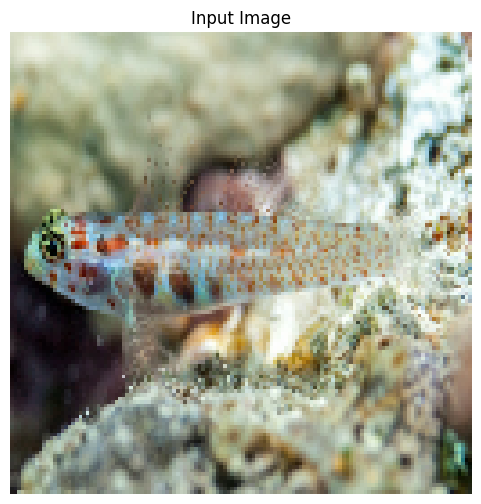

Top 3 Family Predictions:
b'Gobiidae': 0.7746
b'Tripterygiidae': 0.1872
b'Monacanthidae': 0.0225

Top 3 Genus Predictions:
b'Eviota': 0.7300
b'Ucla': 0.0946
b'Pleurosicya': 0.0455

Top 3 Species Predictions:
b'Ucla xenogrammus': 0.3104
b'Enneapterygius tutuilae': 0.0975
b'Eviota albolineata': 0.0839


In [24]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3, image_size=settings['img_size']
)

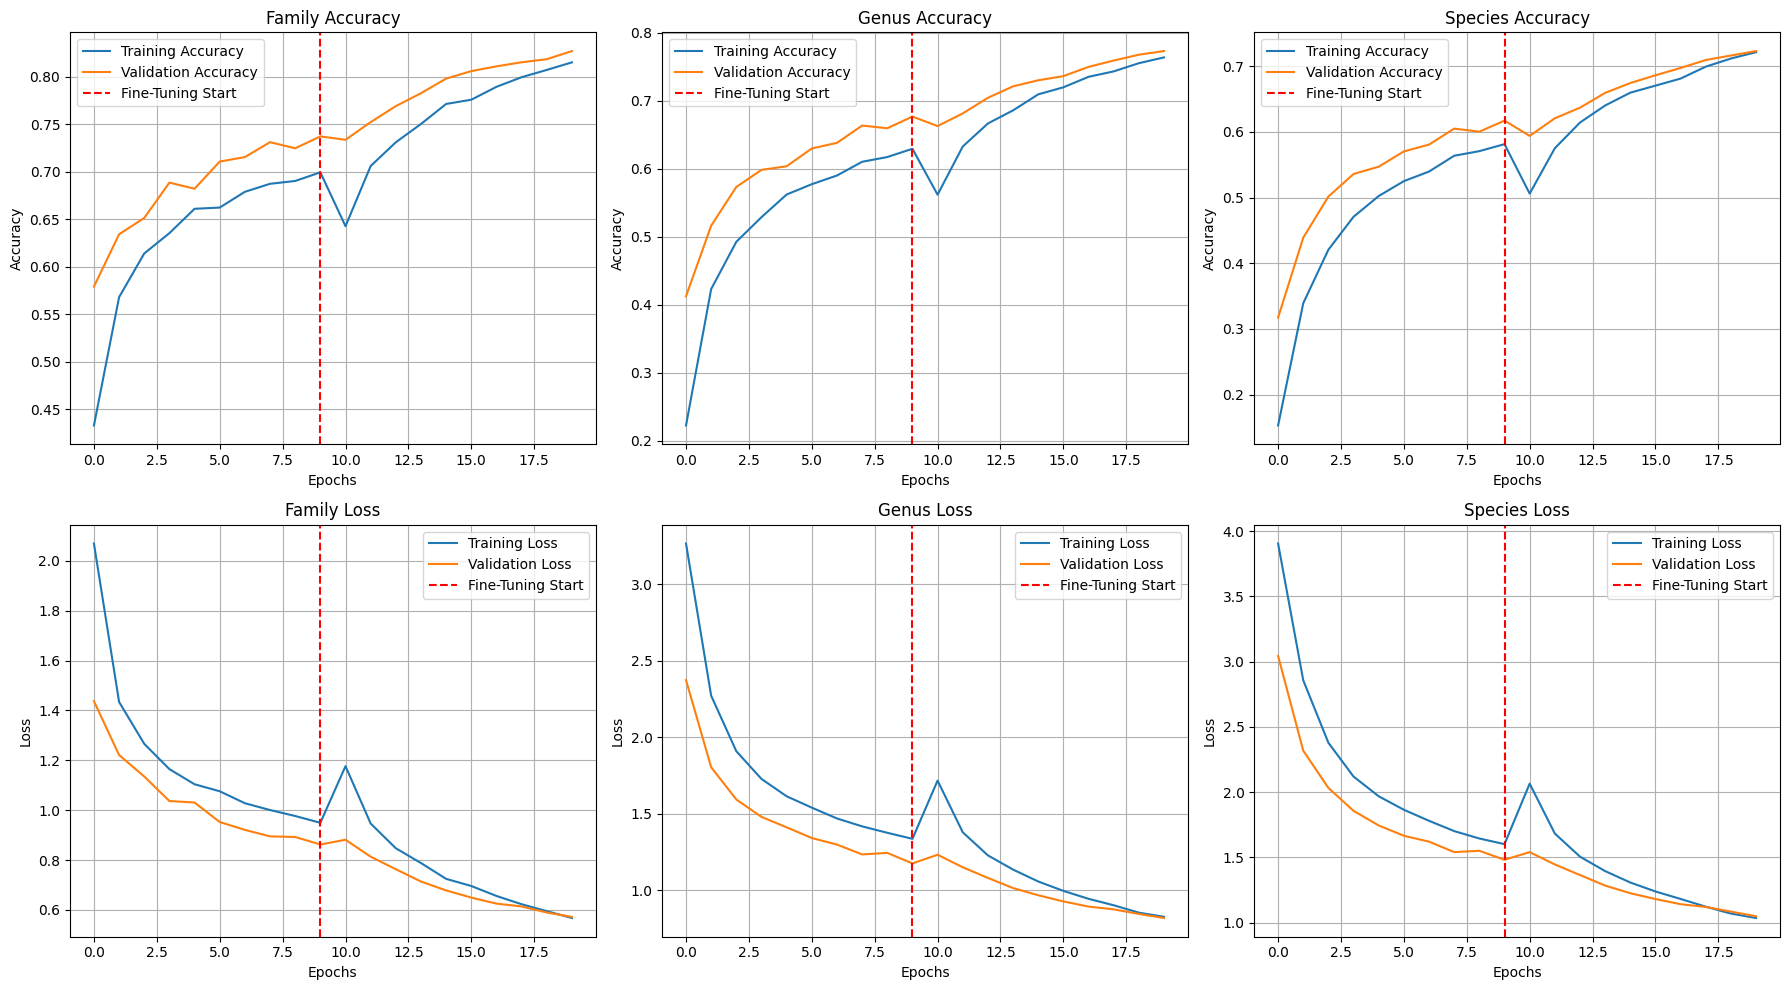

In [25]:
plot_training_history(history, history_fine, fine_tune_at=settings['epochs']-1)

In [27]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/Species_v02"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

2025-01-04 17:35:50.246084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 2601 of 2795
2025-01-04 17:35:51.041018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Genus Misclassifications: 698
Genus Misclassifications Respecting Family: 74 (10.60%)

Top Genus Misclassifications:
         True Genus Predicted Genus  Count
72         Gobiodon     Koumansetta     24
0     Pseudochromis   Paracirrhites     15
29            Cypho     Koumansetta     15
21         Fowleria            Ucla     10
6              Ucla           Eques      9
241        Fowleria          Trimma      8
68             Ucla        Fowleria      8
151  Enneapterygius            Ucla      6
77   Corythoichthys        Fowleria      6
102           Eques        Fowleria      5

Species Misclassifications: 835
Species Misclassifications Respecting Genus: 93 (11.14%)
Species Misclassifications Respecting Family: 257 (30.78%)

Top Species Misclassifications:
                   True Species           Predicted Species  Count
105             Eviota_nebulosa            Gobiodon_brochus     20
0      Paragobiodon_lacunicolus            Gomphosus_varius     14
38     Coryphopterus_person

2025-01-04 17:35:55.971174: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
